# Хакатоним ФинТех

## Содержание

- [Загрузка библиотек](#ch1)
- [Сбор и анализ данных](#ch2)
    - [Анализ тренировочной выборки](#ch21)
- [Создание единой таблицы](#ch3)
- [Визуализация данных КАМРОН](#ch4)
- [Заполнение пропусков числовых переменных АНТОН](#ch5)
- [Заполнение пропусков категориальных переменных АНТОН](#ch6)
- [Стандартизация признаков](#ch7)
- [Приведение категориальных к числовому виду](#ch8)
- [Создание новых признаков](#ch9)
- [Кластеризация АЛИНА](#ch10)
- [Выбор бизнес-метрики](#ch11)
- [Метрики задач машинного обучения, соответствующие цели задачи](#ch12)
- [Предсказательная модель](#ch13)
    - [Multi-output regressor](#ch131)
- [Тестирование модели на тестовых данных](#ch15)
- [Возможные улучшения](#ch15)
- [Вывод](#ch16)

## Загрузка библиотек  <a class="anchor" id="ch1"></a>

In [ ]:
!pip install pingouin

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from sklearn import preprocessing
pd.set_option('display.max_rows', 500)

## Сбор и анализ данных  <a class="anchor" id="ch2"></a>

In [ ]:
!wget  -O 'avk_hackathon_data_test_transactions.csv' -q 'https://www.dropbox.com/s/ysxs5srafoyxknb/_data_3_course.xlsx?dl=1'
!wget  -O 'avk_hackathon_data_story_texts.csv' -q 'https://www.dropbox.com/s/ki8zzf51uxtn39h/avk_hackathon_data_story_texts.csv?dl=0'
!wget  -O 'avk_hackathon_data_party_x_socdem.csv' -q 'https://www.dropbox.com/s/cjlo1edjbnxvp88/avk_hackathon_data_party_x_socdem.csv?dl=0'
!wget  -O 'avk_hackathon_data_party_products.csv' -q 'https://www.dropbox.com/s/vb8fe4yhshd401y/avk_hackathon_data_party_products.csv?dl=0'
!wget  -O 'avk_hackathon_data_account_x_balance.csv' -q 'https://www.dropbox.com/s/i94cotxyti8y7ir/avk_hackathon_data_account_x_balance.csv?dl=0'
!wget  -O 'avk_hackathon_data_train_transactions.csv' -q 'https://www.dropbox.com/s/ui8x3dtpjht3560/avk_hackathon_data_train_transactions.csv?dl=0'
!wget  -O 'avk_hackathon_data_story_logs.csv' -q 'https://www.dropbox.com/s/8oexjpfpn8nqrnn/avk_hackathon_data_story_logs.csv?dl=0'
!wget  -O 'avk_hackathon_data_test_transactions.csv' -q 'https://www.dropbox.com/s/97ik1n6y3osrxug/avk_hackathon_data_test_transactions.csv?dl=0'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# загружаем данные 
df_test = pd.read_csv('avk_hackathon_data_test_transactions.csv', encoding='utf-8')
df_story_texts= pd.read_csv('avk_hackathon_data_story_texts.csv')
df_socdem = pd.read_csv('avk_hackathon_data_party_x_socdem.csv')
df_products = pd.read_csv('avk_hackathon_data_party_products.csv')
df_balance = pd.read_csv('avk_hackathon_data_account_x_balance.csv')
df_train = pd.read_csv('avk_hackathon_data_train_transactions.csv')
df_stories_logs = pd.read_csv('avk_hackathon_data_story_logs.csv')

### Анализ тренировочной выборки  <a class="anchor" id="ch21"></a>

#### df_train

In [ ]:
df_train.head()

,party_rk,account_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,transaction_amt_rur,merchant_rk,merchant_type,merchant_group_rk,category
0,20337,19666,1,2019-01-01,Покупка,84.00,88676.0,348.0,NaN,Сувениры
1,63404,72991,1,2019-01-01,Покупка,410.00,887248.0,330.0,725.0,Фаст Фуд
2,24789,23517,2,2019-01-01,Покупка,701.44,830014.0,291.0,NaN,Супермаркеты
3,57970,64838,2,2019-01-01,Покупка,6203.70,363834.0,278.0,454.0,Дом/Ремонт
4,12232,11591,2,2019-01-01,Покупка,734.53,85919.0,286.0,878.0,Супермаркеты


In [ ]:
print('Количество строк: {}, количество столбцов: {}'.format(df_train.shape[0], df_train.shape[1]))

Количество строк: 11987617, количество столбцов: 10


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11987617 entries, 0 to 11987616
Data columns (total 10 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   party_rk                   int64  
 1   account_rk                 int64  
 2   financial_account_type_cd  int64  
 3   transaction_dttm           object 
 4   transaction_type_desc      object 
 5   transaction_amt_rur        float64
 6   merchant_rk                float64
 7   merchant_type              float64
 8   merchant_group_rk          float64
 9   category                   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 914.6+ MB


Заметим, что у признака 'transaction_dttm', который представляет из себя дату транзакции, тип object, хотя должен бы быть тип datetime.

In [ ]:
df_train['transaction_dttm'] = pd.to_datetime(df_train['transaction_dttm'])

In [ ]:
df_train.describe().round(3)

,party_rk,account_rk,financial_account_type_cd,transaction_amt_rur,merchant_rk,merchant_type,merchant_group_rk
count,1.198762e+07,1.198762e+07,11987617.00,1.198761e+07,1.198664e+07,1.198595e+07,5763654.000
mean,4.300785e+04,5.390717e+04,1.67,3.186888e+03,1.120440e+06,2.666720e+02,785.665
std,2.540438e+04,3.313377e+04,0.47,2.447061e+04,7.462046e+05,1.215150e+02,550.641
min,1.000000e+00,1.000000e+00,1.00,1.000000e+01,4.000000e+00,1.000000e+00,2.000
25%,2.117500e+04,2.537100e+04,1.00,1.599000e+02,4.556840e+05,2.750000e+02,341.000
50%,4.216800e+04,5.146000e+04,2.00,3.910000e+02,1.070370e+06,2.860000e+02,748.000
75%,6.319900e+04,8.032600e+04,2.00,1.225000e+03,1.650108e+06,3.300000e+02,930.000
max,9.461000e+04,1.261720e+05,2.00,2.000010e+07,3.057837e+06,4.980000e+02,2961.000


In [ ]:
print("\nКоличество пропущенных значений:")
df_train.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений:


,merchant_group_rk,category,merchant_type,merchant_rk,transaction_amt_rur,party_rk,account_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc
0,6223963,1881017,1665,976,6,0,0,0,0,0


In [ ]:
df_train['transaction_type_desc'].value_counts().reset_index()

,index,transaction_type_desc
0,Покупка,9157744
1,Платеж,1977602
2,Оплата услуг,581098
3,Снятие наличных,271173


In [ ]:
df_train['category'].value_counts().reset_index()

,index,category
0,Супермаркеты,3938925
1,Фаст Фуд,1007549
2,Транспорт,839906
3,Финансовые услуги,787258
4,Разные товары,531127
5,Рестораны,401255
6,Топливо,398397
7,Аптеки,311316
8,Наличные,271948
9,Дом/Ремонт,268370


In [ ]:
# category - ктегориальный признак, переведем его в тип int
df_train['category'] = df_train['category'].fillna('')
df_train['category'] = df_train['category'].astype(str)

le = preprocessing.LabelEncoder()
le.fit(df_train['category'])
df_train['category'] = le.transform(df_train['category'])

In [ ]:
df_train['transaction_type_desc'].unique()

array(['Покупка', 'Оплата услуг', 'Платеж', 'Снятие наличных'],
      dtype=object)

In [ ]:
# transaction_type_desc - ктегориальный признак, переведем его в тип int
le.fit(df_train['transaction_type_desc'])
df_train['transaction_type_desc'] = le.transform(df_train['transaction_type_desc'])

In [ ]:
df_train = df_train.drop(['account_rk','merchant_rk','merchant_group_rk'], axis = 1)

In [ ]:
df_train

,party_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,transaction_amt_rur,merchant_type,category
0,20337,1,2019-01-01,2,84.00,348.0,27
1,63404,1,2019-01-01,2,410.00,330.0,32
2,24789,2,2019-01-01,2,701.44,291.0,28
3,57970,2,2019-01-01,2,6203.70,278.0,7
4,12232,2,2019-01-01,2,734.53,286.0,28
...,...,...,...,...,...,...,...
11987612,44990,1,2019-12-31,2,121.00,330.0,32
11987613,53023,2,2019-12-31,2,102.29,286.0,28
11987614,78716,1,2019-12-31,2,175.00,229.0,30
11987615,73104,2,2019-12-31,2,185.99,286.0,28


#### df_socdem

In [ ]:
df_socdem.head()

,party_rk,gender_cd,age,marital_status_desc,children_cnt,region_flg
0,61243,F,70.0,NaN,0,0
1,66535,F,25.0,NaN,0,0
2,83721,M,55.0,Женат/замужем,0,0
3,88238,F,35.0,NaN,0,0
4,57179,F,30.0,Женат/замужем,0,0


In [ ]:
'Infant','Toddler','Kid','Teen', 'Adult']

In [ ]:
df_socdem.loc[(df_socdem.age < 21),  'AgeGroup'] = '0-21'
df_socdem.loc[(21 <= df_socdem.age),  'AgeGroup'] = '21-29'
df_socdem.loc[(30 <= df_socdem.age),  'AgeGroup'] = '30-40'
df_socdem.loc[(41 <= df_socdem.age),  'AgeGroup'] = '41-54'
df_socdem.loc[(54 <= df_socdem.age),  'AgeGroup'] = '55-65'
df_socdem.loc[(65 <= df_socdem.age),  'AgeGroup'] = '65+'

In [ ]:
df_socdem

,party_rk,gender_cd,age,marital_status_desc,children_cnt,region_flg,AgeGroup
0,61243,F,70.0,NaN,0,0,65+
1,66535,F,25.0,NaN,0,0,21-29
2,83721,M,55.0,Женат/замужем,0,0,55-65
3,88238,F,35.0,NaN,0,0,30-40
4,57179,F,30.0,Женат/замужем,0,0,30-40
...,...,...,...,...,...,...,...
49995,54994,M,40.0,Женат/замужем,0,0,30-40
49996,63391,M,35.0,Холост/не замужем,0,0,30-40
49997,5418,F,55.0,Холост/не замужем,0,0,55-65
49998,50273,F,35.0,Женат/замужем,0,0,30-40


In [ ]:
# Agegroup - ктегориальный признак, переведем его в тип int
le = preprocessing.LabelEncoder()
le.fit(df_socdem['marital_status_desc'])
df_socdem['AgeGroup'] = le.transform(df_socdem['AgeGroup'])

In [ ]:
# Я НЕ УБИРАЛА NAN
df_socdem['marital_status_desc'] = df_socdem['marital_status_desc'].astype(str)

In [ ]:
le.fit(df_socdem['marital_status_desc'])
df_socdem['marital_status_desc'] = le.transform(df_socdem['marital_status_desc'])

In [ ]:
# Я НЕ УБИРАЛА NAN
df_socdem['gender_cd'] = df_socdem['gender_cd'].astype(str)
le.fit(df_socdem['gender_cd'])
df_socdem['gender_cd'] = le.transform(df_socdem['gender_cd'])

In [ ]:
df_socdem

,party_rk,gender_cd,age,marital_status_desc,children_cnt,region_flg,AgeGroup
0,61243,0,70.0,0,0,0,5
1,66535,0,25.0,0,0,0,1
2,83721,1,55.0,3,0,0,4
3,88238,0,35.0,0,0,0,2
4,57179,0,30.0,3,0,0,2
...,...,...,...,...,...,...,...
49995,54994,1,40.0,3,0,0,2
49996,63391,1,35.0,6,0,0,2
49997,5418,0,55.0,6,0,0,4
49998,50273,0,35.0,3,0,0,2


In [ ]:
print('Количество строк: {}, количество столбцов: {}'.format(df_socdem.shape[0], df_socdem.shape[1]))

Количество строк: 50000, количество столбцов: 6


In [ ]:
df_socdem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   party_rk             50000 non-null  int64  
 1   gender_cd            49989 non-null  object 
 2   age                  50000 non-null  float64
 3   marital_status_desc  37594 non-null  object 
 4   children_cnt         50000 non-null  int64  
 5   region_flg           50000 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 2.3+ MB


In [ ]:
df_socdem.describe()

,party_rk,age,children_cnt,region_flg
count,50000.00000,50000.000000,50000.000000,50000.000000
mean,47339.73202,39.062300,0.388660,0.091900
std,27317.74524,11.675057,0.968928,0.288888
min,1.00000,15.000000,0.000000,0.000000
25%,23669.75000,30.000000,0.000000,0.000000
50%,47434.50000,35.000000,0.000000,0.000000
75%,70961.50000,45.000000,0.000000,0.000000
max,94610.00000,100.000000,4.000000,1.000000


В соц-деме пользователей скорее всего есть вопросы, так как мы видим, что максимальное значение достигает 100, что невозможно. 

In [ ]:
print("\nКоличество пропущенных значений:")
df_socdem.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений:


,marital_status_desc,gender_cd,party_rk,age,children_cnt,region_flg
0,12406,11,0,0,0,0


Заменим пропуски в колонке 'marital_status_desc' на значение unknown, тк возможно, пользователь не захотел указывать свой статус 

In [ ]:
df_socdem['marital_status_desc'].value_counts().reset_index()

,index,marital_status_desc
0,Женат/замужем,17446
1,Холост/не замужем,13045
2,Разведен (а),3696
3,Гражданский брак,2607
4,"Вдовец, вдова",798
5,Не проживает с супругом (ой),2


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


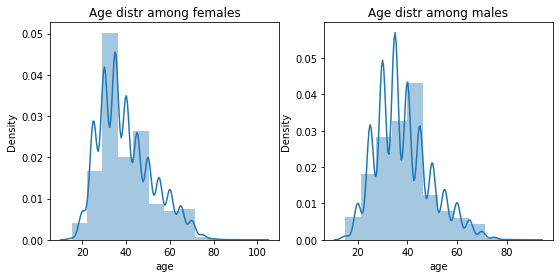

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4))

female = df_socdem[df_socdem['gender_cd'] == 'F']
male = df_socdem[df_socdem['gender_cd'] == 'M']

sns.distplot(female['age'], bins=12 ,ax=ax1)
sns.distplot(male['age'], bins=12, ax=ax2)

ax1.set_title('Age distr among females');
ax2.set_title('Age distr among males');

In [ ]:
df_socdem = df_socdem.drop('age', axis=1)

In [ ]:
df_socdem

,party_rk,gender_cd,marital_status_desc,children_cnt,region_flg,AgeGroup
0,61243,0,0,0,0,5
1,66535,0,0,0,0,1
2,83721,1,3,0,0,4
3,88238,0,0,0,0,2
4,57179,0,3,0,0,2
...,...,...,...,...,...,...
49995,54994,1,3,0,0,2
49996,63391,1,6,0,0,2
49997,5418,0,6,0,0,4
49998,50273,0,3,0,0,2


#### df_balance

In [ ]:
df_balance.head()

,party_rk,account_rk,prev_month,cur_month,balance_chng
0,51607,55309,2018-12-31,2019-01-31,15000.0
1,59074,70471,2018-12-31,2019-01-31,0.0
2,33941,33065,2018-12-31,2019-01-31,-15000.0
3,9336,8611,2018-12-31,2019-01-31,-50000.0
4,13958,8421,2018-12-31,2019-01-31,-20000.0


In [ ]:
print('Количество строк: {}, количество столбцов: {}'.format(df_balance.shape[0], df_balance.shape[1]))

Количество строк: 614434, количество столбцов: 5


In [ ]:
df_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614434 entries, 0 to 614433
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   party_rk      614434 non-null  int64  
 1   account_rk    614434 non-null  int64  
 2   prev_month    612832 non-null  object 
 3   cur_month     612832 non-null  object 
 4   balance_chng  612832 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 23.4+ MB


In [ ]:
df_balance['prev_month'] = pd.to_datetime(df_balance['prev_month'])
df_balance['cur_month'] = pd.to_datetime(df_balance['cur_month'])

In [ ]:
df_balance = df_balance.drop(['account_rk'], axis = 1)

In [ ]:
df_balance

,party_rk,prev_month,cur_month,balance_chng
0,51607,2018-12-31,2019-01-31,15000.0
1,59074,2018-12-31,2019-01-31,0.0
2,33941,2018-12-31,2019-01-31,-15000.0
3,9336,2018-12-31,2019-01-31,-50000.0
4,13958,2018-12-31,2019-01-31,-20000.0
...,...,...,...,...
614429,13734,NaT,NaT,NaN
614430,33502,NaT,NaT,NaN
614431,8735,NaT,NaT,NaN
614432,91302,NaT,NaT,NaN


#### df_stories_texts

In [ ]:
df_story_texts.head()

,story_id,name,story_text
0,794,Профессия: свадебный организатор,"["""",""Как стать свадебным организатором"",""Это Л..."
1,821,Бизнес: магазин электроники,"["""",""Как открыть интернет-магазин электроники""..."
2,824,Как у них: Сингапур,"["""",""Жизнь в Сингапуре"",""Это Славина. Вместе с..."
3,839,Студии йоги,"["""",""Студии йоги"",""7 московских студий, где мо..."
4,848,Как получать больше кэшбэка,"["""",""Как получать больше кэшбэка"",""Подключите ..."


In [ ]:
print('Количество строк: {}, количество столбцов: {}'.format(df_story_texts.shape[0], df_story_texts.shape[1]))

Количество строк: 1631, количество столбцов: 3


In [ ]:
print("\nКоличество пропущенных значений:")
df_story_texts.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений:


,name,story_id,story_text
0,230,0,0


#### df_stories_logs

In [ ]:
df_stories_logs.head()

,party_rk,date_time,story_id,category,event
0,64266,2019-12-01 13:05:31,3840,39,like
1,55721,2019-12-01 13:18:08,3857,39,like
2,27563,2019-12-01 13:25:40,3174,78,like
3,61223,2019-12-01 13:25:20,3857,39,like
4,61223,2019-12-01 13:29:05,3765,73,like


In [ ]:
print('Количество строк: {}, количество столбцов: {}'.format(df_stories_logs.shape[0], df_stories_logs.shape[1]))

Количество строк: 13820, количество столбцов: 5


In [ ]:
df_stories_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13820 entries, 0 to 13819
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   party_rk   13820 non-null  int64 
 1   date_time  13820 non-null  object
 2   story_id   13820 non-null  int64 
 3   category   13820 non-null  int64 
 4   event      13820 non-null  object
dtypes: int64(3), object(2)
memory usage: 540.0+ KB


In [ ]:
df_stories_logs['date_time'] = pd.to_datetime(df_stories_logs['date_time'])

In [ ]:
df_stories_logs['event'].value_counts().reset_index()

,index,event
0,like,5920
1,favorite,5028
2,dislike,763
3,14],592
4,77],551
5,153,208
6,180,108
7,177,99
8,176,72
9,54],54


Удалим строки с непонятными значениями. 

In [ ]:
df_stories_logs = df_stories_logs[(df_stories_logs['event'] == 'like') | (df_stories_logs['event'] =='dislike') | (df_stories_logs['event'] =='favorite')] 

In [ ]:
print("\nКоличество пропущенных значений:")
df_stories_logs.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений:


,party_rk,date_time,story_id,category,event
0,0,0,0,0,0


In [ ]:
# event - ктегориальный признак, переведем его в тип int
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_stories_logs['event'])
df_stories_logs['event'] = le.transform(df_stories_logs['event'])

In [ ]:
df_stories_logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11711 entries, 0 to 13819
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   party_rk   11711 non-null  int64         
 1   date_time  11711 non-null  datetime64[ns]
 2   story_id   11711 non-null  int64         
 3   category   11711 non-null  int64         
 4   event      11711 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 549.0 KB


In [ ]:
df_stories_logs.head()

,party_rk,date_time,story_id,category,event
0,64266,2019-12-01 13:05:31,3840,39,2
1,55721,2019-12-01 13:18:08,3857,39,2
2,27563,2019-12-01 13:25:40,3174,78,2
3,61223,2019-12-01 13:25:20,3857,39,2
4,61223,2019-12-01 13:29:05,3765,73,2


In [ ]:
df_stories_logs['event'].unique()

array([2, 1, 0])

#### df_products

In [ ]:
df_products.head()

,party_rk,product1,product2,product3,product4,product5,product6,product7
0,74874,1,1,0,0,0,0,0
1,83618,0,0,1,1,1,0,0
2,73766,0,0,0,1,1,0,0
3,60218,0,1,0,0,0,0,0
4,47253,0,0,0,1,1,0,0


In [ ]:
print('Количество строк: {}, количество столбцов: {}'.format(df_products.shape[0], df_products.shape[1]))

Количество строк: 50000, количество столбцов: 8


In [ ]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   party_rk  50000 non-null  int64
 1   product1  50000 non-null  int64
 2   product2  50000 non-null  int64
 3   product3  50000 non-null  int64
 4   product4  50000 non-null  int64
 5   product5  50000 non-null  int64
 6   product6  50000 non-null  int64
 7   product7  50000 non-null  int64
dtypes: int64(8)
memory usage: 3.1 MB


In [ ]:
print("\nКоличество пропущенных значений:")
df_products.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений:


,party_rk,product1,product2,product3,product4,product5,product6,product7
0,0,0,0,0,0,0,0,0


## Соединяем все таблицы в одну <a class="anchor" id="ch3"></a>

In [ ]:
# HardCoded creation of dates [first date in every month of 2019]
unique_dates = np.array(['2019-01-01T00:00:00.000000000', '2019-02-01T00:00:00.000000000',
       '2019-03-01T00:00:00.000000000', '2019-04-01T00:00:00.000000000',
       '2019-05-01T00:00:00.000000000', '2019-06-01T00:00:00.000000000',
       '2019-07-01T00:00:00.000000000', '2019-08-01T00:00:00.000000000',
       '2019-09-01T00:00:00.000000000', '2019-10-01T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2019-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

# Constructing DataFrame of every possible combination tripplet (month,category,human)
# through Cartesian product [dates * categories * people_id] 
# There should be 12*37*50000 = 22 200 000 of such triplets

u_dat = pd.DataFrame(unique_dates, columns=['transaction_dttm'])
u_cat= pd.DataFrame(df_train.category.unique(), columns=['category'] )
u_id = pd.DataFrame(df_train.party_rk.unique(), columns=['party_rk'] )

u_dat['key'] = 1
u_cat['key'] = 1
u_id['key'] = 1

df_train2 = pd.merge(u_id, 
                  pd.merge(u_dat, u_cat, on ='key')).drop("key", 1)

# Added zero column for further easy concatation 
df_train2['transaction_amt_rur'] = 0
df_train2.info()

In [ ]:
# Creating minimal sized DataFrame with columns = (transaction_dttm, human_id, category, price)
# Every month for every human should have all 37 categories

# This implemetation adds 0 expenditure for every month beginning to the main training DataFrame
df_main = df_train[['transaction_dttm', 'party_rk', 'category', 'transaction_amt_rur']]
df_main = pd.concat([df_main,df_train2])
df_main.info()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
df_main_sort = df_main.sort_values(by=['transaction_dttm','party_rk'])
df_main_sort.head(100)

In [ ]:
df_socdem_train = df_main_sort.merge(df_socdem, on = 'party_rk', how = 'left')

In [ ]:
df_socdem_train_bal = df_socdem_train.merge(df_balance, on = 'party_rk', how = 'left')

In [ ]:
df_temp = df_socdem_train_bal.merge(df_products, on = 'party_rk', how = 'left')

In [ ]:
df_temp1 = df_temp.merge(df_stories_logs,on = 'party_rk', how = 'left')

In [ ]:
df_final = df_temp1.merge(story_texts, on = 'story_id', how = 'left')

Альтернативно можно намного быстрее так выполнить left join


In [ ]:
df_socdem_train = pd.concat(
    [
     df_main_sort                                      .reset_index(drop=True), 
     df_socdem.reindex(df_main_sort['party_rk'].values).reset_index(drop=True)
     ], 
     axis=1)

## Визуализация данных  <a class="anchor" id="ch4"></a>

In [ ]:
df_cluster = pd.merge(df_train, df_socdem)

In [ ]:
df_category_trans = df_cluster.groupby("category")['transaction_amt_rur'].sum().reset_index().sort_values(by = 'transaction_amt_rur', ascending = False)

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(x="transaction_amt_rur", y="category", data=df_category_trans, orient = 'h');

In [ ]:
df_distr = pd.pivot_table(data = df_cluster[['age', 'transaction_amt_rur', 'children_cnt', 'gender_cd', 'category']], index = ['gender_cd', 'category'])

In [ ]:
df_distr = df_distr.reset_index()

In [ ]:
plt.figure(figsize=(16,10))
sns.lineplot(data= df_distr, x=df_distr['category'], y=df_distr['transaction_amt_rur'], hue=df_distr['gender_cd'])
plt.xticks(rotation=90);